# **Momentum Strategy**
* Author: Tiano Rao
* Last modification: Dec 27 2022

# Outlines
> [Preprocessing](#preprocessing)   

> [Simple Moving Average](#simple-moving-average-sma)       
- [center](#wait-how-about-center)      
- [center example 2](#let-me-give-u-another-example)    

> [SMA Strategy](#strategy-1-----sma-cross)         
- [performance](#performance-of-strategy-1)     
- [Select windows](#tune-sma-windows)   

> [Strategy Performance](#strategy-performance)
- [Sharpe Ratio, Max Drawdown, CAGR](#strategy-performance) 
- [collect all strategy performance](#collect-all-strategy-performance)

> [EMA Straetegy](#strategy-2-----exponential-moving-average-ewm)   
- [performance](#performance-of-strategy-2)     

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas_datareader as pdr
import datetime as dt
import yfinance as yf

# plotting and display style
np.set_printoptions(precision = 3)
plt.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

## Preprocessing

In [2]:
# Using AAPL as an example
ticker = "AAPL"
start = '2018-01-01'
end = '2021-12-31'

df = yf.download(ticker,
                 start = start,
                 end = end,
                 progress = False,
                 auto_adjust = False
                 )


df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950493,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133537,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447338,82271200


In [3]:
df.index = pd.to_datetime(df.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2018-01-02 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1007 non-null   float64
 1   High       1007 non-null   float64
 2   Low        1007 non-null   float64
 3   Close      1007 non-null   float64
 4   Adj Close  1007 non-null   float64
 5   Volume     1007 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1 KB


## Simple Moving Average, SMA



<AxesSubplot:xlabel='Date', ylabel='Price'>

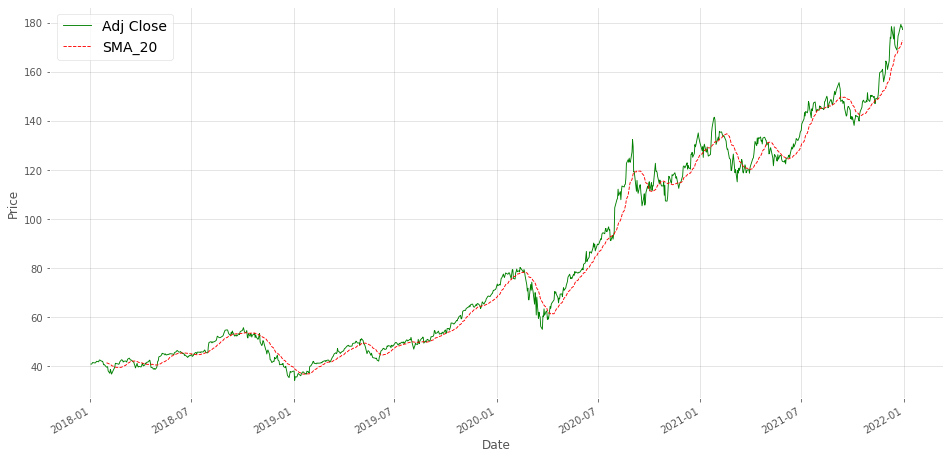

In [4]:
# test window length is 20
window_1 = 20
col_name_1 = f'SMA_{window_1}'

# pd.DataFrame.rolling() to calculate SMA
df_1 = df.copy()
df_1[col_name_1] = df_1['Adj Close'].rolling(window = window_1) \
                                    .mean()

df_1[['Adj Close', col_name_1]].plot(figsize = (16, 8),
                                     style = ["g-", "r--"],
                                     lw = .9,
                                     ylabel = 'Price'
                                     )


## Wait, how about **`center`**?
> Taking rolling window length is 5 as an example
- Center:
$\bar x = x_{t-2} + x_{t-1} + x_{t0} + x_{t+1} + x_{t+2} $ 

- Non-center:
$\bar x = x_{t-4} + x_{t-3} + x_{t-2} + x_{t-1} + x_{t-0} $ 

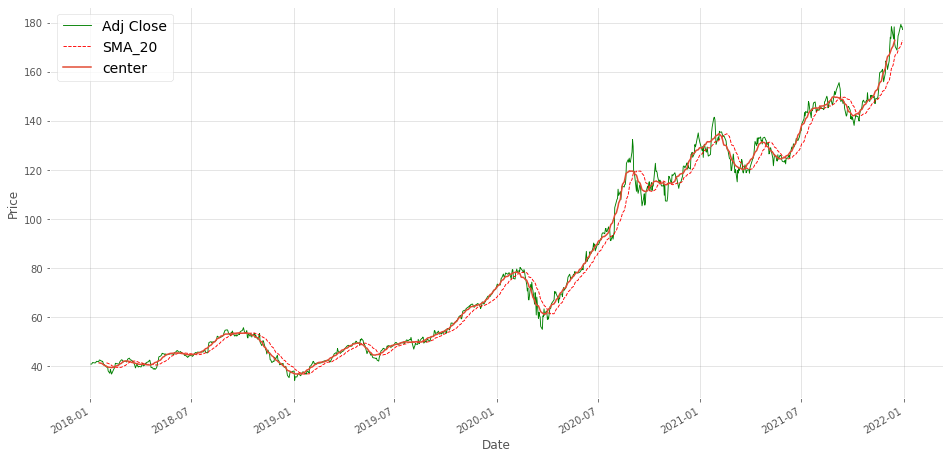

In [5]:
df_1[['Adj Close', col_name_1]].plot(figsize = (16, 8),
                                     style = ["g-", "r--"],
                                     lw = .9,
                                     ylabel = 'Price'
                                     )
df_1['Adj Close'].rolling(window = window_1,
                        center = True
                        ).mean() \
                        .plot(label='center')
plt.legend()
plt.show()

> Clearly, **center** SMA is more accurate

> However, in order to make sure our strategy is realistic, we need to set `center = False`

### Let me give u another example
> let's create a `toy dataframe` to show the difference of w/o `center`

In [6]:
# random seed of numpy
np.random.seed(1)

In [7]:
Toy_df = pd.DataFrame({"x": np.linspace(-2*np.pi, 2*np.pi, 800)
                        }
                        )

Toy_df["y"] = np.sin(Toy_df["x"]
                            )

Toy_df["noisy_y"] = Toy_df["y"] + 0.1 * np.random.standard_normal(len(Toy_df)
                                                                    )

Toy_df

,x,y,noisy_y
0,-6.283185,2.449294e-16,0.162435
1,-6.267458,1.572697e-02,-0.045449
2,-6.251730,3.145006e-02,-0.021367
3,-6.236002,4.716536e-02,-0.060131
4,-6.220275,6.286900e-02,0.149410
...,...,...,...
795,6.220275,-6.286900e-02,-0.185826
796,6.236002,-4.716536e-02,0.063696
797,6.251730,-3.145006e-02,-0.101742
798,6.267458,-1.572697e-02,0.056828


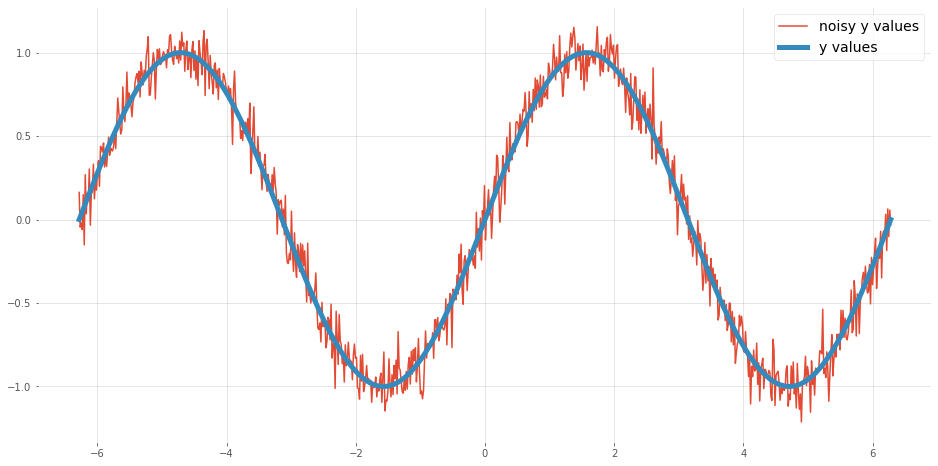

In [8]:
plt.figure(figsize = (16, 8)
          )

plt.plot(Toy_df.x, 
         Toy_df.noisy_y, 
         label = "noisy y values"
         )

plt.plot(Toy_df.x, 
         Toy_df.y, 
         label = "y values",
         linewidth = 5)

plt.legend()
plt.show()

In [9]:
# center SMA
Toy_df["centered_SMA"] = Toy_df.noisy_y.rolling(50, 
                                                center = True
                                                ).mean()
# noncenter SMA
Toy_df["non_centered_SMA"] = Toy_df.noisy_y.rolling(50, 
                                                    center = False
                                                    ).mean()

Toy_df.tail()

,x,y,noisy_y,centered_SMA,non_centered_SMA
795,6.220275,-6.286900e-02,-0.185826,NaN,-0.432239
796,6.236002,-4.716536e-02,0.063696,NaN,-0.417220
797,6.251730,-3.145006e-02,-0.101742,NaN,-0.404670
798,6.267458,-1.572697e-02,0.056828,NaN,-0.389799
799,6.283185,-2.449294e-16,-0.032420,NaN,-0.374841


In [10]:
# find first max value as benchmark
max_index_original = Toy_df \
                    .y \
                    .sort_values(ascending = False) \
                    .index[0]
max_index_original

100

In [11]:
max_index_centered = Toy_df \
                    .centered_SMA \
                    .sort_values(ascending = False) \
                    .index[0]
max_index_centered

102

In [12]:
max_index_non_centered = Toy_df \
                        .non_centered_SMA \
                        .sort_values(ascending = False) \
                        .index[0]
max_index_non_centered

126

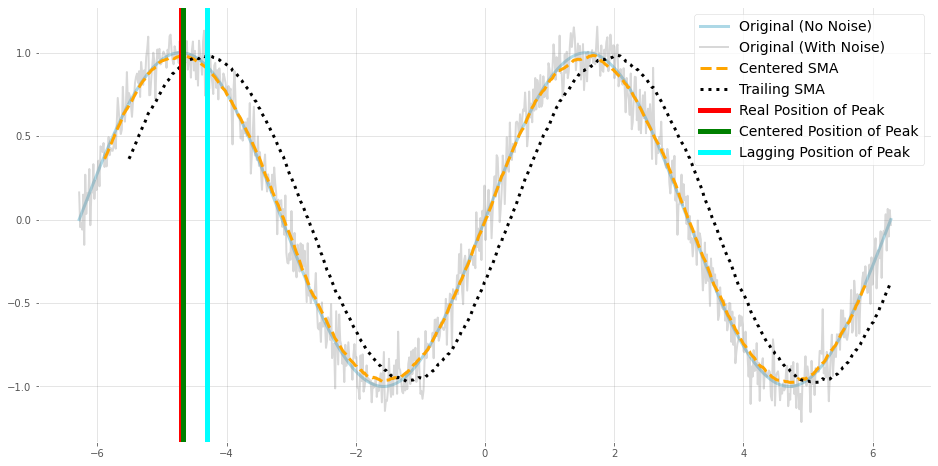

In [13]:
plt.figure(figsize = (16, 8)
          )

plt.plot(Toy_df.x, Toy_df.y,
         label = "Original (No Noise)",
         color = "lightblue",
         linewidth = 3)


plt.plot(Toy_df.x, Toy_df.noisy_y,
         label = "Original (With Noise)",
         color = "gray",
         alpha = 0.3,
         linewidth = 2)

plt.plot(Toy_df.x, Toy_df.centered_SMA,
         "--",
         color = "orange",
         label = "Centered SMA",
         linewidth = 3)

plt.plot(Toy_df.x, Toy_df.non_centered_SMA,
         ":",
         color = "black",
         label = "Trailing SMA",
         linewidth = 3)

plt.axvline(Toy_df.x[max_index_original], 
            color = "red",
            linewidth = 5, 
            label = "Real Position of Peak")

plt.axvline(Toy_df.x[max_index_centered], 
            color = "green",
            linewidth = 5, 
            label = "Centered Position of Peak")

plt.axvline(Toy_df.x[max_index_non_centered], 
            color = "cyan",
            linewidth = 5, 
            label = "Lagging Position of Peak")

plt.legend(loc = "upper right")
plt.show()

> We can observe the impact of `center` in this plotting    

* Center SMA is more accuarte

## Strategy 1 --- ***SMA Cross***
### Let's frist go step-by-step

Here we gonna set two windows, short window length is 10 and long window length is 30

- Go `long` on a stock when its `shorter-term SMA is above its longer-term SMA`, and should go short when the opposite holds true.

- `DataFrame` will help with alloctae our positions.

In [14]:
short_window = 10
long_window = 30

df_2 = df.copy()

def get_SMA(df, window_length, col_name):
    df[col_name] = df['Adj Close'].rolling(window_length) \
                                  .mean()

get_SMA(df_2, short_window, 'SHORT_SMA')
get_SMA(df_2, long_window, 'LONG_SMA')

df_2

,Open,High,Low,Close,Adj Close,Volume,SHORT_SMA,LONG_SMA
Date,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950493,102223600,NaN,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600,NaN,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133537,89738400,NaN,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000,NaN,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447338,82271200,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.279999,175.262802,68356600,173.679997,164.408475
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.289444,74919600,173.767491,165.484232
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255447,79144300,174.120444,166.455263


<AxesSubplot:xlabel='Date'>

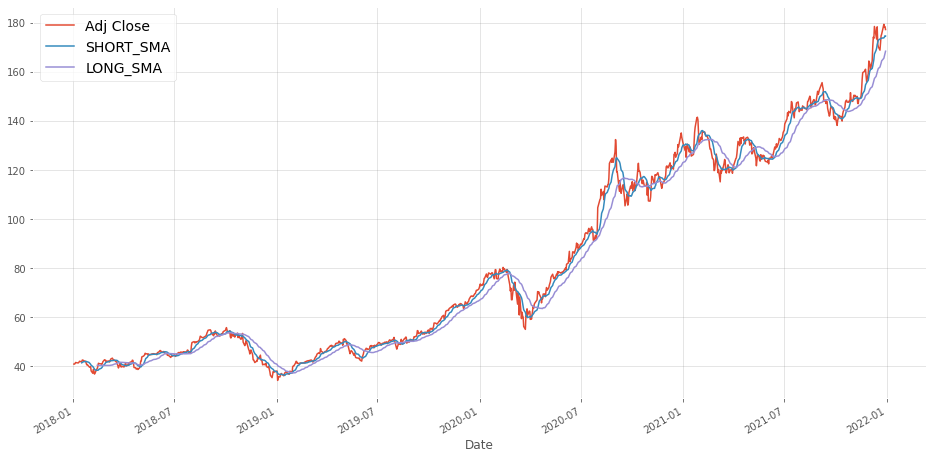

In [15]:
df_2[["Adj Close", "SHORT_SMA", "LONG_SMA"]].plot(figsize = (16, 8)
                                                                )

In [16]:
# Set long/short position
df_2.loc[short_window:, 'position'] = np.where(df_2["SHORT_SMA"][short_window:] > df_2["LONG_SMA"][short_window:],
                                                1.0, 
                                                0.0)
df_2

/var/folders/mc/q8l3qkxd5g7_ksnvysll6jlr0000gn/T/ipykernel_31960/4088459964.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_2.loc[short_window:, 'position'] = np.where(df_2["SHORT_SMA"][short_window:] > df_2["LONG_SMA"][short_window:],


,Open,High,Low,Close,Adj Close,Volume,SHORT_SMA,LONG_SMA,position
Date,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950493,102223600,NaN,NaN,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600,NaN,NaN,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133537,89738400,NaN,NaN,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000,NaN,NaN,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447338,82271200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.279999,175.262802,68356600,173.679997,164.408475,1.0
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.289444,74919600,173.767491,165.484232,1.0
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255447,79144300,174.120444,166.455263,1.0


In [17]:
# BUY / SELL
df_2['trade'] = df_2['position'].diff()
df_2


,Open,High,Low,Close,Adj Close,Volume,SHORT_SMA,LONG_SMA,position,trade
Date,,,,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.950493,102223600,NaN,NaN,NaN,NaN
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.943363,118071600,NaN,NaN,NaN,NaN
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.133537,89738400,NaN,NaN,NaN,NaN
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.601860,94640000,NaN,NaN,NaN,NaN
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.447338,82271200,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.279999,175.262802,68356600,173.679997,164.408475,1.0,0.0
2021-12-27,177.089996,180.419998,177.070007,180.330002,179.289444,74919600,173.767491,165.484232,1.0,0.0
2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255447,79144300,174.120444,166.455263,1.0,0.0


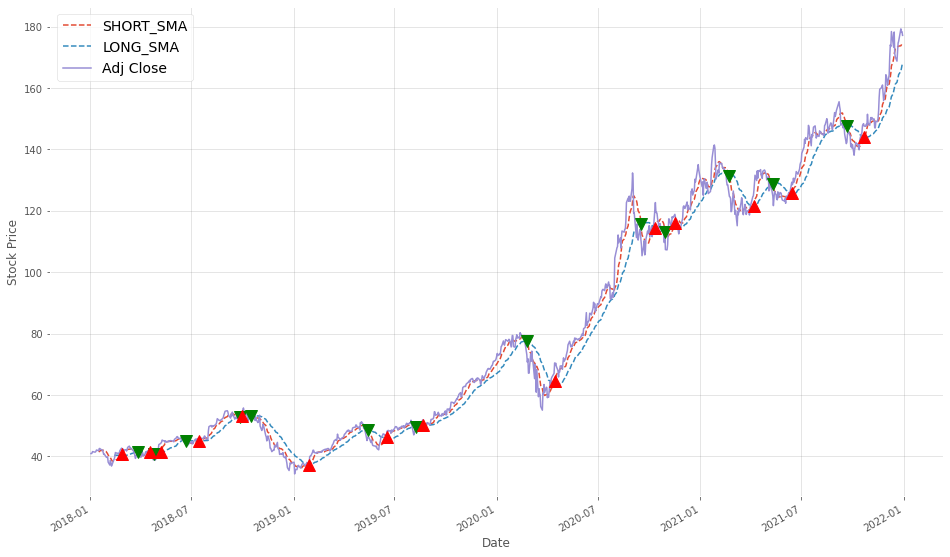

In [18]:
fig = plt.figure(figsize = (16, 10)) # For your plot initialization

sub = fig.add_subplot(111, # For adding a subplot
                      ylabel = "Stock Price")

df_2[["SHORT_SMA", # For Short and Long MA
        "LONG_SMA",
        "Adj Close"]].plot(ax = sub,
                            style = ["--",
                                    "--",
                                    '-'])

# Sell
sub.plot(df_2.loc[df_2.trade == -1.0].index,
         df_2.SHORT_SMA[df_2.trade == -1.0],
         "v",
         markersize = 12,
         color = "green")

# # Buy
sub.plot(df_2.loc[df_2.trade == 1.0].index,
         df_2.SHORT_SMA[df_2.trade == 1.0],
         "^",
         markersize = 12,
         color = "red")


In [19]:
sum(abs(df_2['trade'].dropna()))

27.0

In [20]:
# Calculate our strategy culmulative return
df_2['return'] = df_2['Adj Close'].pct_change()

df_2['strategy_return'] = df_2['return'] * df_2['position']

df_2['cumulative_return'] = (1+df_2['strategy_return']).cumprod()

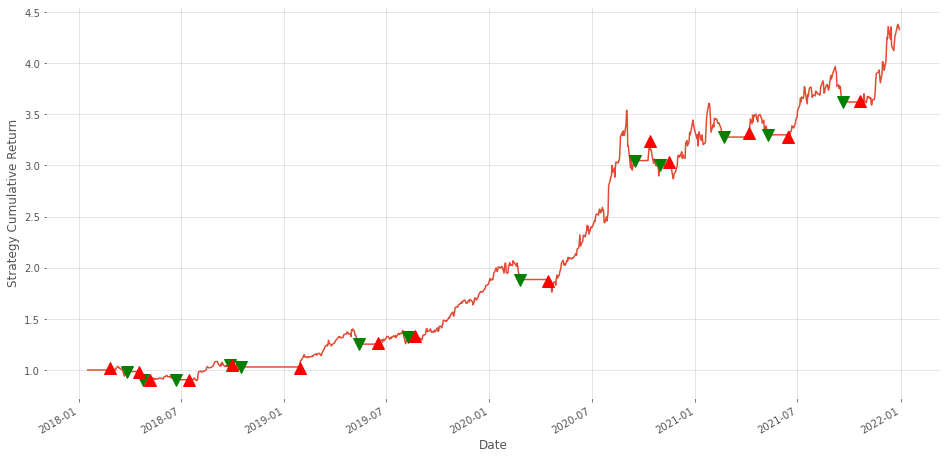

In [21]:
fig = plt.figure(figsize = (16, 10)) # For your plot initialization

sub = fig.add_subplot(111, # For adding a subplot
                      ylabel = "Strategy Cumulative Return")

df_2['cumulative_return'].plot(figsize = (16, 8)
                                )

# Sell
sub.plot(df_2.loc[df_2.trade == -1.0].index,
         df_2.cumulative_return[df_2.trade == -1.0],
         "v",
         markersize = 12,
         color = "green")

# # Buy
sub.plot(df_2.loc[df_2.trade == 1.0].index,
         df_2.cumulative_return[df_2.trade == 1.0],
         "^",
         markersize = 12,
         color = "red")


* Set initial wealth = $50,000

<AxesSubplot:xlabel='Date'>

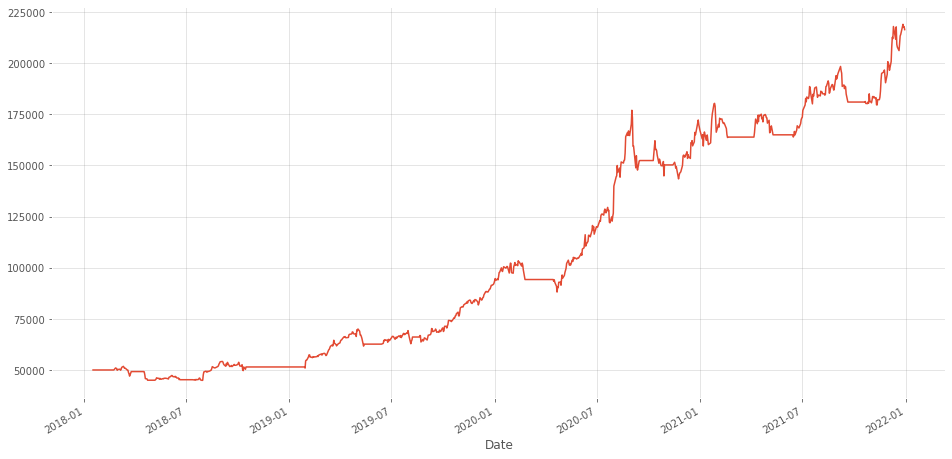

In [22]:
df_2['wealth'] = df_2['cumulative_return'] * 50000.0
df_2['wealth'].plot(figsize=(16,8))

# **Strategy Performance**
### `Sharpe ratio`
$$
Sharpe Ratio = \frac{r_{p} - r_{f}}{\sigma_{p}}
$$

### `Maximum drawdown`


### `Compond Annual Growth Rate (CAGR)`
- First, let’s calculate CAGR by dividing the investment’s ending value (EV) by its beginning value (BV).
- Then, raise the result to the power of 1/n, where n is the number of periods.
- Subtract 1 from the result. This is the CAGR.
$$ CAGR = (EV/BV)^{1/n} - 1 $$


In [23]:
# sharpe ratio
def sharpe(return_series):
    return return_series.mean()/return_series.std()

In [24]:
# max drawdown (annual)
def max_drawdown(value):
    max_gross_performance = value.cummax()
    DRAWDOWN = (max_gross_performance - value) / max_gross_performance
    
    # PERIOD = (DRAWDOWN[DRAWDOWN == 0].index[1:].to_pydatetime() - 
    #         DRAWDOWN[DRAWDOWN == 0].index[:-1].to_pydatetime()
    #         )
    # we can also try to calculate the max drown period

    return DRAWDOWN.max()

In [25]:
# CAGR
def CAGR(price_series):
    D = (price_series.index[-1] - price_series[0]).days
    return (((price_series[-1]) / (price_series[1])) ** (365.0/D)) - 1

## Collect all strategy performance
> use `class` to collect all strategy performance   
- `__init__`: initital capital = 50,000    
- `.add_strategy()`: add strategy to `performance` and calculate some performance metrics       
- `.output_result()`: ouput performance as a `DataFrame`

In [26]:
class performance():
    '''
    Collect all strategy result and compare.
    '''

    def __init__(self, data):
        # instrument
        self.df = data
        # initial capital
        self.capital = 500000.0
        # performance datframe to collect all results
        self.performance = pd.DataFrame([], index=[] ,columns=['Strategy_name', 
                                                               'Cumulative_return', 
                                                               'Sharpe', 
                                                               'CAGR', 
                                                               'Max_drawdown', 

                                                               'Final_portfolio_value']
                                                               ).set_index(['Strategy_name']
                                                                            )
        # strategy name
        self.strategy_name_list = []
        # Instrument pnl as baseline
        self.performance.loc['return',:] = np.array([(data['return']+1).cumprod()[-1],#return the cumulative return along a given axis
                                                    sharpe(data['return']),
                                                    CAGR(data['Adj Close']),
                                                    max_drawdown(data['Adj Close']),
                                                    self.capital*((data['return']+1).cumprod()[-1])#calculate the final portfolio value
                                                ],dtype=object)
    
    
    def add_strategy(self, strategy_return, portfolio_value, strategy_name):
        # sharpe ratio
        sharpe_ratio = sharpe(strategy_return)
        
        # CAGR
        CAGR1 = CAGR(portfolio_value)

        # max drawdown
        max_drawdown1 = max_drawdown(portfolio_value)#.max()

        # cash left in the account at final
        # cash = cash
    
        # collect the strategy name 
        self.strategy_name_list.append(strategy_name)

        self.performance.loc[strategy_name, :] = np.array([(strategy_return+1).cumprod()[-1],
                                                    sharpe_ratio,
                                                    CAGR1,
                                                    max_drawdown1,
                                                    portfolio_value.iloc[-1]
                                                    ],dtype=object)
        print('------------------------------------------------------------------')
        print(f'Add startegy {strategy_name}')
        # print('------------------------------------------------------------------')
        

    def output_result(self):
        print(f"There are a total  {len(self.strategy_name_list)} strategies.")
        print("Output performance of all strategy.")
        return self.performance

## Performance of strategy 1

In [27]:
print(f"Sharpe ratio of momentum strategy is %.3f." %sharpe(df_2['strategy_return']))

print(f"Annual max drawdown is %.3f." %max_drawdown(df_2['wealth']))

print(f"CAGR is %.3f" %CAGR(df_2['wealth'].dropna()))

Sharpe ratio of momentum strategy is 0.111.
Annual max drawdown is 0.190.


TypeError: unsupported operand type(s) for -: 'Timestamp' and 'float'

# Tune SMA windows

In [ ]:
class window_len_tune():
    def __init__(self, data):
        self.df = data
        self.window_list = []
        self.capital = float(500000.0)
        self.result = []
        self.name_list = []

    def try_sma(self, LONG, SHORT, visual=False):
        BUY_or_SELL = pd.DataFrame(index = self.df.index)
        BUY_or_SELL["BUY_or_SELL"] = 0.0
        BUY_or_SELL["short_moving_average"] = self.df["Adj Close"].rolling(SHORT,
                                                                  center=False  
                                                                  ).mean()

        BUY_or_SELL["long_moving_average"] = self.df["Adj Close"].rolling(LONG,
                                                                center=False  
                                                                ).mean()

        BUY_or_SELL["BUY_or_SELL"][SHORT:] = np.where(BUY_or_SELL["short_moving_average"][SHORT:] > 
                                              BUY_or_SELL["long_moving_average"][SHORT:],
                                              1.0, 
                                              0.0)
                                
        
        BUY_or_SELL["our_positions"] = BUY_or_SELL["BUY_or_SELL"].diff()

        if visual == True:
            fig = plt.figure(figsize = (16, 10)) # For your plot initialization

            sub = fig.add_subplot(111, # For adding a subplot
                                ylabel = "Stock Price")

            self.df["Close"].plot(ax = sub, # For the closing price
                            color = "grey")

            BUY_or_SELL[["short_moving_average", # For Short and Long MA
                        "long_moving_average"]].plot(ax = sub,
                                                    style = ["--",
                                                            "--"]
                                                    ) 
            #plot
            # Selling
            sub.plot(BUY_or_SELL.loc[BUY_or_SELL.our_positions == -1.0].index,
                    BUY_or_SELL.short_moving_average[BUY_or_SELL.our_positions == -1.0],
                    "v",
                    markersize = 12,
                    color = "green")

            # Buying
            sub.plot(BUY_or_SELL.loc[BUY_or_SELL.our_positions == 1.0].index,
                    BUY_or_SELL.short_moving_average[BUY_or_SELL.our_positions == 1.0],
                    "^",
                    markersize = 12,
                    color = "red")

            plt.show()

        else: 
            pass
        
        # self.result.append(BUY_or_SELL['BUY_or_SELL'].values)
        self.window_list.append([SHORT,LONG])
        self.name_list.append(f"SMA_{SHORT}_{LONG}")

        # all-in
        BUY_or_SELL['strategy'] = BUY_or_SELL["BUY_or_SELL"] * self.df['return']
        BUY_or_SELL['portfolio_value'] = self.capital *  (BUY_or_SELL['strategy']+1).cumprod()

        BUY_or_SELL.dropna(inplace=True)

        self.result.append(BUY_or_SELL)

        # return BUY_or_SELL

    def summary(self, performance1):
        for i in range(len(self.result)):
            performance1.add_strategy(self.result[i]['strategy'], 
                                      self.result[i]['portfolio_value'], 
                                      self.name_list[i]
                                      )



In [ ]:
sma_cross_strategy =  window_len_tune(df_2)

for long in range(50, 100, 5):#long term between 50days and 100days,5days steps each
    for short in range(20, long, 5):#short between 20days and long,not exceeding the long term
        sma_cross_strategy.try_sma(long,short)

In [ ]:
performance_sma = performance(df_2)

sma_cross_strategy.summary(performance_sma)


------------------------------------------------------------------
Add startegy SMA_20_50
------------------------------------------------------------------
Add startegy SMA_25_50
------------------------------------------------------------------
Add startegy SMA_30_50
------------------------------------------------------------------
Add startegy SMA_35_50
------------------------------------------------------------------
Add startegy SMA_40_50
------------------------------------------------------------------
Add startegy SMA_45_50
------------------------------------------------------------------
Add startegy SMA_20_55
------------------------------------------------------------------
Add startegy SMA_25_55
------------------------------------------------------------------
Add startegy SMA_30_55
------------------------------------------------------------------
Add startegy SMA_35_55
------------------------------------------------------------------
Add startegy SMA_40_55
----------

In [ ]:
sma_result = performance_sma.output_result()

sma_result.sort_values(['Cumulative_return'],ascending=False)

There are a total  105 strategies.
Output performance of all strategy.


,Cumulative_return,Sharpe,CAGR,Max_drawdown,Final_portfolio_value
Strategy_name,,,,,
return,4.326485,0.080691,0.443015,0.385159,2163242.656424
SMA_20_50,3.637273,0.096815,0.407388,0.224142,1818636.29135
SMA_20_65,3.517691,0.091164,0.40694,0.2078,1758845.445452
SMA_20_55,3.361159,0.091097,0.391616,0.203756,1680579.560926
SMA_20_60,3.350453,0.089014,0.380317,0.203756,1675226.600309
...,...,...,...,...,...
SMA_40_70,2.221286,0.056019,0.234865,0.304876,1110643.113666
SMA_70_95,2.20166,0.054617,0.246687,0.352379,1100830.133835
SMA_65_75,2.172552,0.054031,0.233217,0.314273,1086276.210982


# Strategy 2 --- ***Exponential Moving Average, EWM***

In [ ]:
class ema_tune():
    def __init__(self, data):
        self.df = data
        self.window_list = []
        self.capital = float(500000.0)
        self.result = []
        self.name_list = []

    def try_ema(self, LONG, SHORT, visual=False):
        BUY_or_SELL = pd.DataFrame(index = self.df.index)
        BUY_or_SELL["BUY_or_SELL"] = 0.0
        BUY_or_SELL["short_moving_average"] = self.df["Close"].ewm(span = SHORT,
                                                            min_periods = SHORT).mean()
                        
        BUY_or_SELL["long_moving_average"] = self.df["Close"].ewm(span = LONG,
                                                            min_periods = LONG).mean()

        BUY_or_SELL["BUY_or_SELL"][SHORT:] = np.where(BUY_or_SELL["short_moving_average"][SHORT:] > 
                                              BUY_or_SELL["long_moving_average"][SHORT:],
                                              1.0, 
                                              0.0)
                                
        
        BUY_or_SELL["our_positions"] = BUY_or_SELL["BUY_or_SELL"].diff()

        if visual == True:
            fig = plt.figure(figsize = (16, 10)) # For your plot initialization

            sub = fig.add_subplot(111, # For adding a subplot
                                ylabel = "Stock Price")

            self.df["Close"].plot(ax = sub, # For the closing price
                            color = "grey")

            BUY_or_SELL[["short_moving_average", # For Short and Long MA
                        "long_moving_average"]].plot(ax = sub,
                                                    style = ["--",
                                                            "--"]
                                                    ) 
            #plot
            # Selling
            sub.plot(BUY_or_SELL.loc[BUY_or_SELL.our_positions == -1.0].index,
                    BUY_or_SELL.short_moving_average[BUY_or_SELL.our_positions == -1.0],
                    "v",
                    markersize = 12,
                    color = "green")

            # Buying
            sub.plot(BUY_or_SELL.loc[BUY_or_SELL.our_positions == 1.0].index,
                    BUY_or_SELL.short_moving_average[BUY_or_SELL.our_positions == 1.0],
                    "^",
                    markersize = 12,
                    color = "red")

            plt.show()

        else: 
            pass
        
        # self.result.append(BUY_or_SELL['BUY_or_SELL'].values)
        self.window_list.append([SHORT,LONG])
        self.name_list.append(f"EMA_{SHORT}_{LONG}")

        # all-in
        BUY_or_SELL['strategy'] = BUY_or_SELL["BUY_or_SELL"] * self.df['return']
        BUY_or_SELL['portfolio_value'] = self.capital *  (BUY_or_SELL['strategy']+1).cumprod()

        BUY_or_SELL.dropna(inplace=True)

        self.result.append(BUY_or_SELL)

        # return BUY_or_SELL

    def summary(self, performance1):
        for i in range(len(self.result)):

            performance1.add_strategy(self.result[i]['strategy'], 
                                      self.result[i]['portfolio_value'], 
                                      self.name_list[i]
                                      )

In [ ]:
ema_cross_strategy =  ema_tune(df_2)

for long in range(100, 200, 10):#long term between 200days and 1000days
    for short in range(10, long, 10):#short term betwwen 10days and long term,not exceeding the long term
       ema_cross_strategy.try_ema(long,short)

performance_ema = performance(df_2)
ema_cross_strategy.summary(performance_ema)

------------------------------------------------------------------
Add startegy EMA_10_100
------------------------------------------------------------------
Add startegy EMA_20_100
------------------------------------------------------------------
Add startegy EMA_30_100
------------------------------------------------------------------
Add startegy EMA_40_100
------------------------------------------------------------------
Add startegy EMA_50_100
------------------------------------------------------------------
Add startegy EMA_60_100
------------------------------------------------------------------
Add startegy EMA_70_100
------------------------------------------------------------------
Add startegy EMA_80_100
------------------------------------------------------------------
Add startegy EMA_90_100
------------------------------------------------------------------
Add startegy EMA_10_110
------------------------------------------------------------------
Add startegy EMA_20_110

## Performance of strategy 2

In [ ]:
ema_result = performance_ema.output_result()
ema_result.sort_values(['Cumulative_return'],ascending=False)

There are a total  135 strategies.
Output performance of all strategy.


,Cumulative_return,Sharpe,CAGR,Max_drawdown,Final_portfolio_value
Strategy_name,,,,,
return,4.326485,0.080691,0.443015,0.385159,2163242.656424
EMA_10_130,3.972034,0.094813,0.481108,0.241351,1986016.910465
EMA_10_120,3.932774,0.093771,0.482055,0.241351,1966387.011395
EMA_10_100,3.78896,0.094574,0.446489,0.212013,1894480.001182
EMA_10_110,3.698239,0.093365,0.44799,0.212013,1849119.269106
...,...,...,...,...,...
EMA_130_190,2.115054,0.054429,0.251419,0.452333,1057526.991874
EMA_140_170,2.111616,0.053506,0.253476,0.452333,1055807.930742
EMA_150_170,2.087444,0.052845,0.249141,0.458152,1043722.159072
